In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# Loading and normalizing CIFAR10

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                       download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4,
                                        shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                       download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 4,
                                        shuffle = False, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Show images

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [22]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

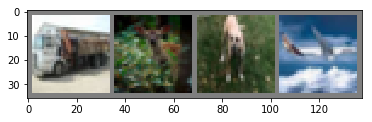

truck  deer   dog plane


In [23]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

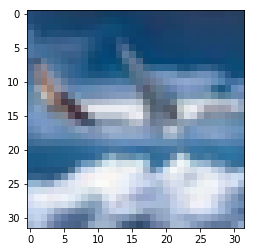

In [30]:
imshow(images[3])

In [33]:
images[3].size()

torch.Size([3, 32, 32])

# Define a Convolutional Neural Network

In [35]:
import torch.nn as nn
import torch.nn.functional as F

In [51]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))        
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [63]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [53]:
### to define the appropiated number for fc1
# input = torch.randn(1, 3, 32, 32)
# out = net(input)
# print(out.shape)
# out: torch.Size([1, 16, 5, 5])

In [58]:
input = torch.randn(1, 3, 32, 32)
out = net(input)

# Define a Loss function and optimizer

In [59]:
import torch.optim as optim

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

# Train the network

In [66]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.256
[1,  4000] loss: 1.912
[1,  6000] loss: 1.708
[1,  8000] loss: 1.598
[1, 10000] loss: 1.528
[1, 12000] loss: 1.479
[2,  2000] loss: 1.386
[2,  4000] loss: 1.371
[2,  6000] loss: 1.359
[2,  8000] loss: 1.332
[2, 10000] loss: 1.278
[2, 12000] loss: 1.291
Finished Training


In [67]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Test the network on the test data

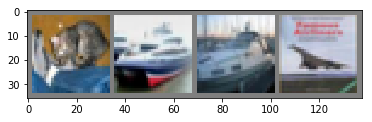

GroundTruth:    cat  ship  ship plane


In [68]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [69]:
net = Net()

In [70]:
outputs = net(images)

In [72]:
print(outputs)

tensor([[-0.0919,  0.0006, -0.0573, -0.0316,  0.0565, -0.1052, -0.0222,  0.0339,
         -0.0829,  0.1041],
        [-0.1054,  0.0047, -0.0533, -0.0239,  0.0518, -0.1133, -0.0199,  0.0412,
         -0.0871,  0.0976],
        [-0.1036, -0.0004, -0.0514, -0.0237,  0.0544, -0.1155, -0.0215,  0.0365,
         -0.0828,  0.1049],
        [-0.0980, -0.0019, -0.0505, -0.0272,  0.0607, -0.1088, -0.0134,  0.0414,
         -0.0872,  0.1008]], grad_fn=<AddmmBackward>)


In [74]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  truck truck truck truck


In [76]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [77]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


## test: whole dataset

In [80]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [82]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Predicted:   frog   dog  deer horse
GroundTruth:    cat   dog   car horse


In [83]:
(predicted == labels)

tensor([False,  True, False,  True])

In [84]:
(predicted == labels).sum()

tensor(2)

In [85]:
(predicted == labels).sum().item()

2

In [88]:
labels.size(0)

4

In [89]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 62 %
Accuracy of  bird : 39 %
Accuracy of   cat : 40 %
Accuracy of  deer : 27 %
Accuracy of   dog : 44 %
Accuracy of  frog : 74 %
Accuracy of horse : 71 %
Accuracy of  ship : 64 %
Accuracy of truck : 69 %


In [90]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print(predicted)
print(labels)

tensor([6, 5, 4, 7])
tensor([3, 5, 1, 7])


In [97]:
(predicted == labels)

tensor([False,  True, False,  True])

In [98]:
(predicted == labels).squeeze()

tensor([False,  True, False,  True])

In [100]:
c = (predicted == labels).squeeze()
c[1].item()

True